# Memecoin active trading strategy on Base

- Gaussian process optimiser
- Discover parameter combinations
- Add `min_volatility_threshold` search

# Set up

Set up Trading Strategy data client.


In [1]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Collection of parameters used in the calculations

In [2]:
import datetime

import pandas as pd
from pandas.tseries.offsets import MonthBegin

from skopt.space import Integer, Real, Categorical

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.default_routing_options import TradeRouting


class Parameters:

    id = "34-eth-optimiser-lookbac"

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_4h
    
    # Coingecko categories to include
    #
    # See list here: TODO
    #
    chain_id = ChainId.ethereum
    categories = {"Meme"}
    exchanges = {"uniswap-v2", "uniswap-v3"}
    
    #
    # Basket construction and rebalance parameters
    #
    min_asset_universe = 5  # How many assets we need in the asset universe to start running the index

    # How many assets our basket can hold once
    max_assets_in_portfolio = 30
    allocation = 0.95  # Allocate all cash to volatile pairs
    # min_rebalance_trade_threshold_pct = 0.05  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 75.0  # Don't make buys less than this amount    
    per_position_cap_of_pool = 0.01  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.33 # How large % can one asset be in a portfolio once
    min_portfolio_weight = 0.0050  # Close position / do not open if weight is less than 50 BPS

    min_signal_threshold = Categorical([
        #0.025,
        0.05,
        #0.075,
        #0.10,
        0.125,
        #0.150,
        0.175,
    ])
    
    #
    # Inclusion criteria parameters:
    # - We set the length of various indicators used in the inclusion criteria
    # - We set minimum thresholds neede to be included in the index to filter out illiquid pairs
    #

    # For the length of trailing sharpe used in inclusion criteria
    trailing_sharpe_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()  # How many bars to use in trailing sharpe indicator
    # How many bars to use in volatility indicator
    rebalance_volalitity_bars = Categorical([
        pd.Timedelta("4d") // candle_time_bucket.to_timedelta(),
        pd.Timedelta("2d") // candle_time_bucket.to_timedelta(),
        #pd.Timedelta("1d") // candle_time_bucket.to_timedelta(),
        pd.Timedelta("12h") // candle_time_bucket.to_timedelta(),
        #pd.Timedelta("8h") // candle_time_bucket.to_timedelta(),
    ])
    returns_bars = Categorical([
        #pd.Timedelta("14d") // candle_time_bucket.to_timedelta(),
        pd.Timedelta("10d") // candle_time_bucket.to_timedelta(),
        pd.Timedelta("7d") // candle_time_bucket.to_timedelta(),
        #pd.Timedelta("220h") // candle_time_bucket.to_timedelta(),
        #pd.Timedelta("140h") // candle_time_bucket.to_timedelta(),
        #pd.Timedelta("100h") // candle_time_bucket.to_timedelta(),
        pd.Timedelta("3d") // candle_time_bucket.to_timedelta(),
    ])
    rolling_volume_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rolling_liquidity_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    ewm_span = 200  # How many bars to use in exponential moving average for trailing sharpe smoothing
    tvl_ewm_span = 200  # How many bars to use in EWM smoothing of TVLs
    min_volume = 50_000   # USD
    min_liquidity = 200_000  # USD
    min_tvl = 25_000  # USD
    min_token_sniffer_score = 30  # Scam filter

    #
    # Credit integration
    #
    use_aave = False
    
    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2023, 5, 3)
    backtest_end = datetime.datetime(2025, 1, 11)
    initial_cash = 10_000
    min_trade_count = 50  # Used in optimiser/grid search to filter out invvalid results

    # How do we build the time-local parameters
    optimiser_lookback_period = datetime.timedelta(days=120)
    optimiser_checkpoint_period = MonthBegin(1)  # Month start

    #
    # Live only
    #
    routing = TradeRouting.default
    required_history_period = datetime.timedelta(days=2*14 + 1)
    slippage_tolerance = 0.0060  # 0.6% 
    assummed_liquidity_when_data_missings = 10_000
    

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [3]:
import warnings

from tradingstrategy.alternative_data.coingecko import CoingeckoUniverse, categorise_pairs
from tradingstrategy.chain import ChainId
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume
from tradingstrategy.client import Client
from tradingstrategy.client import Client

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data, OHLCVCandleType
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradingstrategy.utils.token_extra_data import filter_scams
from tradingstrategy.lending import LendingProtocolType
from tradeexecutor.analysis.pair import display_strategy_universe

from eth_defi.token import USDC_NATIVE_TOKEN



# We define our main trading universe,
# and then Ethereum mainnet as a validation set
if Parameters.chain_id == ChainId.base:
    SUPPORTING_PAIRS = [
        (ChainId.base, "uniswap-v2", "WETH", "USDC", 0.0030),  
        (ChainId.base, "uniswap-v3", "cbBTC", "WETH", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "AIXBT", 
        "PEPE",
        "KEYCAT",
        "WETH",
    ]

    VOL_PAIR = (ChainId.base, "uniswap-v2", "WETH", "USDC", 0.0030)

elif Parameters.chain_id == ChainId.ethereum:
    SUPPORTING_PAIRS = [
        (ChainId.ethereum, "uniswap-v2", "WETH", "USDC", 0.0030),  
        (ChainId.ethereum, "uniswap-v3", "WBTC", "USDC", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "PEPE",
        "Neiro",
        "APU",
        "WETH",
    ]
    VOL_PAIR = (ChainId.ethereum, "uniswap-v2", "WETH", "USDC", 0.0030)

else:
    raise NotImplementedError("Chain not supported")


#: Needed for USDC credit
LENDING_RESERVES  = [
    (Parameters.chain_id, LendingProtocolType.aave_v3, "USDC"),
]


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset
    
    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    print(f"Loading backtesting data for {universe_options.start_at} - {universe_options.end_at}")

    chain_id = Parameters.chain_id
    categories = Parameters.categories

    coingecko_universe = CoingeckoUniverse.load()
    print("Coingecko universe is", coingecko_universe)

    exchange_universe = client.fetch_exchange_universe()
    pairs_df = client.fetch_pair_universe().to_pandas()

    # Drop other chains to make the dataset smaller to work with
    chain_mask = pairs_df["chain_id"] == Parameters.chain_id.value
    pairs_df = pairs_df[chain_mask]

    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    pair_universe = PandasPairUniverse(pairs_df, exchange_universe=exchange_universe)
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in SUPPORTING_PAIRS]

    # Assign categories to all pairs
    category_df = categorise_pairs(coingecko_universe, pairs_df)

    # Get all trading pairs that are memecoin, across all coingecko data
    mask = category_df["category"].isin(categories)
    category_pair_ids = category_df[mask]["pair_id"]

    our_pair_ids = list(category_pair_ids) + benchmark_pair_ids

    # From these pair ids, see what trading pairs we have on Ethereum mainnet
    pairs_df = pairs_df[pairs_df["pair_id"].isin(our_pair_ids)]

    # Limit by DEX
    pairs_df = pairs_df[pairs_df["exchange_slug"].isin(Parameters.exchanges)]

    # Never deduplicate supporrting pars
    supporting_pairs_df = pairs_df[pairs_df["pair_id"].isin(benchmark_pair_ids)]
    
    # Deduplicate trading pairs - Choose the best pair with the best volume
    deduplicated_df = deduplicate_pairs_by_volume(pairs_df)
    pairs_df = pd.concat([deduplicated_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')

    print(
        f"Total {len(pairs_df)} pairs to trade on {chain_id.name} for categories {categories}",        
    )

    # Scam filter using TokenSniffer
    pairs_df = filter_scams(pairs_df, client, min_token_sniffer_score=Parameters.min_token_sniffer_score)
    pairs_df = pairs_df.sort_values("volume", ascending=False)

    uni_v2 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v2"]
    uni_v3 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v3"]
    print(f"Pairs on Uniswap v2: {len(uni_v2)}, Uniswap v3: {len(uni_v3)}")

    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=True,
        liquidity_time_bucket=TimeBucket.d1,  
        liquidity_query_type=OHLCVCandleType.tvl_v2,
    )

    reserve_asset = USDC_NATIVE_TOKEN[chain_id.value]

    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset=reserve_asset,
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
    )


    # Tag benchmark/routing pairs tokens so they can be separated from the rest of the tokens
    # for the index construction.
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = True

    return strategy_universe

    
strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)

display_strategy_universe(strategy_universe)


Loading backtesting data for 2023-05-03 00:00:00 - 2025-01-11 00:00:00
Coingecko universe is <CoingeckoUniverse for 2460 tokens>
Total 113 pairs to trade on ethereum for categories {'Meme'}
After scam filter we have 105 pairs
Scammy pair TRUMP - WETH, risk score 0.0, pool 0x56bc8f3293f53825c9fbd6ddfe0cafefa82820d0, token 0x6aa56e1d98b3805921c170eb4b3fe7d4fda6d89b
Scammy pair BabyDoge - WETH, risk score 0.0, pool 0x9f2ebe69a86c079f3d4c3b94a11932b676b72f74, token 0xac57de9c1a09fec648e93eb98875b212db0d460b
Scammy pair VOLT - WETH, risk score 25.0, pool 0x96aa22baedc5a605357e0b9ae20ab6b10a472e03, token 0x7f792db54b0e580cdc755178443f0430cf799aca
Scammy pair GSWIFT - WETH, risk score nan, pool 0x715a3ceac0d039d674f50b07804592e87e8c6d77, token 0x580e933d90091b9ce380740e3a4a39c67eb85b4c
Scammy pair Puff - WETH, risk score 25.0, pool 0x0275885d271c9e5ae7d4aa15ae6c1bcb7e5ae2b8, token 0x31b6100f5f4466e6daeb1edb2f2ce6e548cf8938
Scammy pair DEGEN - WETH, risk score 5.0, pool 0xff6f80f2574096c4613a6

Data missing warning: We asked OHLCV data for 105 trading pairs, but only got for 104 pairs. This is usually because time period 2023-05-03 00:00:00 - 2025-01-11 00:00:00 does not have OHLCV data for all asked pairs.


Loading TVL/liquidity data for 105 pairs:   0%|          | 0/105 [00:00<?, ?it/s]

/Users/moo/code/trade-executor/deps/trading-strategy/tradingstrategy/transport/cache.py:912: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



base quote    exchange  fee %      type:        price  \
id                                                                    
1             WETH  USDC  uniswap-v2    0.3  benchmark      3267.70   
7717         LEASH  WETH  uniswap-v2    0.3     traded       271.59   
33231         HOGE  WETH  uniswap-v2    0.3     traded         0.00   
36926        KISHU  WETH  uniswap-v2    0.3     traded  <not avail>   
37316         ELON  WETH  uniswap-v2    0.3     traded         0.00   
68900        FLOKI  WETH  uniswap-v2    0.3     traded         0.00   
83008        TSUKA  USDC  uniswap-v2    0.3     traded         0.01   
2697640       SHIB  WETH  uniswap-v3    0.3     traded         0.00   
2697647       WBTC  USDC  uniswap-v3    0.3  benchmark     94506.85   
2699739       GHST  WETH  uniswap-v3    1.0     traded         0.93   
2701164       BONE  WETH  uniswap-v3    0.3     traded         0.46   
2701769        NFD  WETH  uniswap-v3    1.0     traded         0.00   
2711945     PEOPLE  WETH  uniswap-v3    1.0     traded         0.04   
2713084        SHI  WETH  uniswap-v3    0.3     traded         0.00   
2715717    OMIKAMI  WETH  uniswap-v2    0.3     traded         0.05   
2734754      $ROAR  WETH  uniswap-v2    0.3     traded         0.01   
2785201      LMEOW  WETH  uniswap-v2    0.3     traded         0.03   
2833961     KIBSHI  WETH  uniswap-v2    0.3     traded         0.00   
2894712    OPTIMUS  WETH  uniswap-v2    0.3     traded         0.06   
2964906      LUFFY  WETH  uniswap-v2    0.3     traded         0.00   
3000217       KATA  WETH  uniswap-v3    1.0     traded         0.00   
3010484       PEPE  WETH  uniswap-v2    0.3     traded         0.00   
3015124      WOJAK  WETH  uniswap-v2    0.3     traded         0.00   
3017331      TROLL  WETH  uniswap-v2    0.3     traded         0.00   
3018875        BOB  WETH  uniswap-v2    0.3     traded         0.00   
3026347       OSAK  WETH  uniswap-v2    0.3     traded         0.00   
3031971      JESUS  WETH  uniswap-v2    0.3     traded         0.00   
3033402      $MONG  WETH  uniswap-v2    0.3     traded         0.00   
3038307   pepecoin  WETH  uniswap-v2    0.3     traded         1.93   
3047249      TURBO  WETH  uniswap-v3    0.3     traded         0.01   
3054571        BAD  WETH  uniswap-v2    0.3     traded         0.00   
3061151      LADYS  WETH  uniswap-v2    0.3     traded         0.00   
3073705       BOBO  WETH  uniswap-v2    0.3     traded         0.00   
3073784    BITCOIN  WETH  uniswap-v3    1.0     traded         0.17   
3079399       PIKA  WETH  uniswap-v2    0.3     traded         0.00   
3145487        CAT  WETH  uniswap-v2    0.3     traded  <not avail>   
3213475      BRETT  WETH  uniswap-v2    0.3     traded         0.13   
3216759      $WOLF  WETH  uniswap-v2    0.3     traded         0.00   
3226046        Mog  WETH  uniswap-v2    0.3     traded         0.00   
3242770        NPC  WETH  uniswap-v2    0.3     traded         0.02   
3271833        SPX  WETH  uniswap-v2    0.3     traded         1.11   
3308171       PSPS  WETH  uniswap-v2    0.3     traded         0.01   
3311668   шайлушай  WETH  uniswap-v2    0.3     traded         0.00   
3319606        APX  WETH  uniswap-v2    0.3     traded         0.00   
3335894     KIZUNA  WETH  uniswap-v3    1.0     traded         0.00   
3347784        JOE  WETH  uniswap-v2    0.3     traded         0.03   
3350536       NATI  WETH  uniswap-v2    0.3     traded         0.00   
3361302       BCAT  WETH  uniswap-v2    0.3     traded         0.01   
3365484        DOG  WETH  uniswap-v3    0.3     traded         0.00   
3367917      Kekec  WETH  uniswap-v2    0.3     traded         0.00   
3376429       MEME  WETH  uniswap-v3    1.0     traded         0.01   
3377643       GROK  WETH  uniswap-v2    0.3     traded         0.01   
3402904       Bonk  WETH  uniswap-v3    1.0     traded         0.00   
3430630        ZYN  WETH  uniswap-v2    0.3     traded         0.03   
3445245       BYTE  WETH  uniswap-v2  

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [4]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# print(f"Pair count is {strategy_universe.get_pair_count()}")
# for symbol, pair in token_map.items():
#    print(f"{symbol} - #{pair.internal_id}")

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 105 assets
Category trading pairs 103
Benchmark trading pairs 2


# Indicators

- Precalculate indicators used by the strategy

In [5]:
import pandas as pd
import numpy as np
from IPython.display import HTML

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry
from tradeexecutor.analysis.indicator import display_indicators


indicators = IndicatorRegistry()


@indicators.define()
def trailing_sharpe(
    close: pd.Series, 
    trailing_sharpe_bars: int
) -> pd.Series:
    """Calculate trailing 30d or so returns / standard deviation.

    :param length:
        Trailing period. 
    
    :return:
        Rolling cumulative returns / rolling standard deviation

        Note that this trailing sharpe is not annualised.
    """
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    returns = close.pct_change()
    mean_returns = returns.rolling(window=trailing_sharpe_bars).mean()    
    vol = returns.rolling(window=trailing_sharpe_bars).std()
    return mean_returns / vol * np.sqrt(ann_factor)


@indicators.define(dependencies=(trailing_sharpe,), source=IndicatorSource.dependencies_only_per_pair)
def trailing_sharpe_ewm(
    trailing_sharpe_bars: int,
    ewm_span: float,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Expontentially weighted moving average for Sharpe.

    :param ewm_span:
        How many bars to consider in the EVM

    """
    trailing_sharpe = dependency_resolver.get_indicator_data(
        "trailing_sharpe",
        pair=pair,
        parameters={"trailing_sharpe_bars": trailing_sharpe_bars},
    )    
    ewm = trailing_sharpe.ewm(span=ewm_span)
    return ewm.mean()


@indicators.define()
def volatility(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    return rolling_std



@indicators.define()
def signed_volatility(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Volatility with returns sign (profit or loss)."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()

    returns =  close \
        .rolling(window=rebalance_volalitity_bars) \
        .agg(lambda x: x.iloc[-1] - x.iloc[0])
    returns_sign = returns.apply(np.sign)
    return rolling_std * returns_sign


@indicators.define()
def rolling_returns(
    close: pd.Series, 
    returns_bars: int    
) -> pd.Series:
    """Rolling returns for the signal period."""

    def _agg_func(window: pd.Series) -> float:

        if len(window) < 2:
            return 0

        try:
            return (window.iloc[-1] - window.iloc[0]) / window.iloc[0]
        except Exception as e:
            raise # Drop into the debugger here

    returns = close.rolling(window=returns_bars).agg(_agg_func)
    return returns


@indicators.define(dependencies=[rolling_returns])
def volatility_returns_indicator(
    close: pd.Series, 
    rebalance_volalitity_bars: int,
    returns_bars: int,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Figure out some indicator to predict the price."""

    returns = dependency_resolver.get_indicator_data(
        rolling_returns,
        parameters={"returns_bars": returns_bars},
        pair=pair,
    )

    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    return rolling_std * returns



@indicators.define()
def volatility_ewm(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    # We are operating on 1h candles, 14d window
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    ewm = rolling_std.ewm(span=14*8)
    return ewm.mean()   


@indicators.define()
def mean_returns(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    # Descripton: TODO
    returns = close.pct_change()
    mean_returns = returns.rolling(window=rebalance_volalitity_bars).mean()    
    return mean_returns


@indicators.define()
def rolling_cumulative_volume(volume: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=rolling_volume_bars).sum()
    return rolling_volume


@indicators.define()
def rolling_liquidity_avg(close: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=rolling_volume_bars).mean()
    return rolling_liquidity_close

    
@indicators.define(dependencies=(rolling_cumulative_volume,), source=IndicatorSource.strategy_universe)
def volume_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate pair volume inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    TODO: Add liquidity check later

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """

    series = dependency_resolver.get_indicator_data_pairs_combined(
        rolling_cumulative_volume,
        parameters={"rolling_volume_bars": rolling_volume_bars},
    )

    # Get mask for days when the rolling volume meets out criteria
    mask = series >= min_volume
    mask_true_values_only = mask[mask == True]

    # Turn to a series of lists
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series


@indicators.define(dependencies=(volatility_ewm,), source=IndicatorSource.strategy_universe)
def volatility_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate volatility inclusion criteria.

    - Include pairs that are above our threshold signal

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(
       volatility_ewm,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    threshold_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    assert threshold_pair
    threshold_signal = dependency_resolver.get_indicator_data(
        volatility_ewm,
        pair=threshold_pair,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    assert threshold_signal is not None, "No threshold volatility signal for: {threshold_pair}"

    # Get mask for days when the rolling volume meets out criteria,
    # and max out the threshold signal if there is
    # mask = filtered_series >= threshold_signal
    df = series.reset_index()
    df2 = df.merge(threshold_signal, on=["timestamp"], suffixes=('_pair', '_reference'))

    #         pair_id           timestamp  value_pair  value_reference
    # 0       4569519 2024-02-13 16:00:00    0.097836              NaN
    # 1       4569519 2024-02-13 17:00:00    0.097773              NaN

    high_volatility_rows = df2[df2["value_pair"] >= df2["value_reference"]]

    def _get_pair_ids_as_list(rows):
        return rows["pair_id"].tolist()
    
    # Turn to a series of lists
    series = high_volatility_rows.groupby(by=['timestamp']).apply(_get_pair_ids_as_list)
    assert isinstance(series, pd.Series)
    return series


@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
) -> pd.Series:
    """Get TVL series for a pair.

    - Because TVL data is 1d and we use 1h everywhere else, we need to forward fill

    - Use previous hourly close as the value
    """
    return close.resample("1h").ffill()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_per_pair)
def tvl_ewm(
    pair: TradingPairIdentifier,
    tvl_ewm_span: float,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Get smoothed TVL series for a pair.

    - Interpretation: If you set span=5, for example, the ewm function will compute an exponential moving average where the weight of the most recent observation is about 33.3% (since α=2/(5+1)≈0.333) and this weight decreases exponentially for older observations.

    - We forward fill gaps, so there is no missing data in decide_trades()    

    - Currently unused in the strategy itself
    """
    tvl_ff = dependency_resolver.get_indicator_data(
        tvl,
        pair=pair,
    )    
    return tvl_ff.ewm(span=tvl_ewm_span).mean()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_universe)
def tvl_inclusion_criteria(   
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """The pair must have min XX,XXX USD one-sided TVL to be included.

    - If the Uniswap pool does not have enough ETH or USDC deposited, skip the pair as a scam

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(tvl)
    mask = series >= min_tvl
    # Turn to a series of lists
    mask_true_values_only = mask[mask == True]
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(
    source=IndicatorSource.strategy_universe
)
def trading_availability_criteria(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Is pair tradeable at each hour.

    - The pair has a price candle at that
    - Mitigates very corner case issues that TVL/liquidity data is per-day whileas price data is natively per 1h
      and the strategy inclusion criteria may include pair too early hour based on TVL only,
      leading to a failed attempt to rebalance in a backtest
    - Only relevant for backtesting issues if we make an unlucky trade on the starting date
      of trading pair listing

    :return:
        Series with with index (timestamp) and values (list of pair ids trading at that hour)
    """
    # Trading pair availability is defined if there is a open candle in the index for it.
    # Because candle data is forward filled, we should not have any gaps in the index.
    candle_series = strategy_universe.data_universe.candles.df["open"]
    pairs_per_timestamp = candle_series.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return pairs_per_timestamp


@indicators.define(
    dependencies=[
        volume_inclusion_criteria,
        volatility_inclusion_criteria,
        tvl_inclusion_criteria,
        trading_availability_criteria
    ],
    source=IndicatorSource.strategy_universe
)
def inclusion_criteria(
    strategy_universe: TradingStrategyUniverse,
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Pairs meeting all of our inclusion criteria.

    - Give the tradeable pair set for each timestamp

    :return:
        Series where index is timestamp and each cell is a list of pair ids matching our inclusion criteria at that moment
    """

    # assert type(rebalance_volalitity_bars) == int, f"Got: {rebalance_volalitity_bars}"

    # Filter out benchmark pairs like WETH in the tradeable pair set
    benchmark_pair_ids = set(strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS)

    volatility_series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    volume_series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={
            "min_volume": min_volume,
            "rolling_volume_bars": rolling_volume_bars,
        },
    )

    tvl_series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={
            "min_tvl": min_tvl,
        },
    )

    trading_availability_series = dependency_resolver.get_indicator_data(trading_availability_criteria)

    #
    # Process all pair ids as a set and the final inclusion
    # criteria is union of all sub-criterias
    #

    df = pd.DataFrame({
        "tvl_pair_ids": tvl_series,
        "volume_pair_ids": volume_series,
        "volatility_pair_ids": volatility_series,
        "trading_availability_pair_ids": trading_availability_series,
    })

    # https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
    df = df.fillna("").apply(list)

    # Volatility criteria removed so we get truly equally weighted index
    # def _combine_criteria(row):
    #     final_set = set(row["volume_pair_ids"]) & set(row["volatility_pair_ids"]) & set(row["tvl_pair_ids"])
    #     return final_set - benchmark_pair_ids

    def _combine_criteria(row):
        final_set = set(row["volume_pair_ids"]) & \
                    set(row["tvl_pair_ids"]) & \
                    set(row["trading_availability_pair_ids"])
        return final_set - benchmark_pair_ids

    union_criteria = df.apply(_combine_criteria, axis=1)

    # Inclusion criteria data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=union_criteria.index.min(),
        end=union_criteria.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    reindexed = union_criteria.reindex(full_index, fill_value=[])
    return reindexed


@indicators.define(dependencies=(volume_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volume_included_pair_count(
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={"min_volume": min_volume, "rolling_volume_bars": rolling_volume_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(volatility_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volatility_included_pair_count(
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(tvl_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def tvl_included_pair_count(
        min_tvl: USDollarAmount,
        dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={"min_tvl": min_tvl},
    )
    series = series.apply(len)

    # TVL data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=series.index.min(),
        end=series.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    # Reindex and fill NaN with zeros
    reindexed = series.reindex(full_index, fill_value=0)
    return reindexed



@indicators.define(dependencies=(inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count(
    min_volume: USDollarAmount,
    min_tvl: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "inclusion_criteria",
        parameters={
            "min_volume": min_volume, 
            "min_tvl": min_tvl, 
            "rolling_volume_bars": rolling_volume_bars,
            "rebalance_volalitity_bars": rebalance_volalitity_bars,
        },
    )
    return series.apply(len)


@indicators.define(source=IndicatorSource.strategy_universe)
def trading_pair_count(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Get number of pairs that trade at each timestamp.

    - Pair must have had at least one candle before the timestamp to be included

    - Exclude benchmarks pairs we do not trade

    :return:
        Series with pair count for each timestamp
    """

    benchmark_pair_ids = {strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS}

    # Get pair_id, timestamp -> timestamp, pair_id index
    series = strategy_universe.data_universe.candles.df["open"]    
    swap_index = series.index.swaplevel(0, 1)

    seen_pairs = set()
    seen_data = {}

    for timestamp, pair_id in swap_index:
        if pair_id in benchmark_pair_ids:
            continue
        seen_pairs.add(pair_id)
        seen_data [timestamp] = len(seen_pairs)

    series = pd.Series(seen_data.values(), index=list(seen_data.keys()))
    return series


@indicators.define(dependencies=(volatility_ewm,), source=IndicatorSource.strategy_universe)
def volume_weighted_avg_volatility(
    strategy_universe,
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate the volume-weighted volatility for the whole index.

    This does not make really sense, but we calculate anyway.

    :return:
        Series with pair count for each timestamp
    """

    volatility_series = dependency_resolver.get_indicator_data_pairs_combined(
        volatility_ewm,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    volume_series = strategy_universe.data_universe.candles.df["volume"]

    # Create DataFrames for easier manipulation
    df = pd.DataFrame({
        'volatility': volatility_series,
        'volume': volume_series
    })
        
    df['weighted'] = df['volatility'] * df['volume']

    # Group by timestamp and calculate weighted average
    grouped = df.groupby(level='timestamp')
    
    volume_weighted_volatility = (
        grouped['weighted'].sum() / grouped['volume'].sum()
    )
    
    return volume_weighted_volatility


@indicators.define(dependencies=(volatility_ewm,), source=IndicatorSource.strategy_universe)
def avg_volatility(
    strategy_universe,
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate index avg volatility across all trading pairs.

    :return:
        Series with pair count for each timestamp
    """

    volatility = dependency_resolver.get_indicator_data_pairs_combined(
        "volatility",
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    n_std = 3
    def remove_outliers_group(group):
        mean = group.mean()
        std = group.std()
        lower_bound = mean - n_std * std
        upper_bound = mean + n_std * std
        return group[(group >= lower_bound) & (group <= upper_bound)]
    
    cleaned = volatility.groupby(level='timestamp').apply(remove_outliers_group)
    
    # Group by timestamp, remove outliers within each group, then calculate mean
    cleaned_volatility = cleaned.groupby(level=0).mean()
    
    return cleaned_volatility


@indicators.define(dependencies=(volatility_returns_indicator,), source=IndicatorSource.dependencies_only_universe)
def avg_signal(
    rebalance_volalitity_bars: int,
    returns_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate our "signal" across all pairs

    :return:
        Series with pair count for each timestamp
    """

    signal = dependency_resolver.get_indicator_data_pairs_combined(
        volatility_returns_indicator,
        parameters={
            "rebalance_volalitity_bars": rebalance_volalitity_bars,
            "returns_bars": returns_bars,
        },
    )

    n_std = 3
    def remove_outliers_group(group):
        mean = group.mean()
        std = group.std()
        lower_bound = mean - n_std * std
        upper_bound = mean + n_std * std
        return group[(group >= lower_bound) & (group <= upper_bound)]
    
    cleaned = signal.groupby(level='timestamp').apply(remove_outliers_group)
    
    # Group by timestamp, remove outliers within each group, then calculate mean
    cleaned_avg_signal = cleaned.groupby(level=0).mean()
    
    return cleaned_avg_signal



# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [6]:
# Get the first date where the condition is True
backtest_start = Parameters.backtest_start
backtest_end = Parameters.backtest_end

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2023-05-03 00:00:00 - 2025-01-11 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [7]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, IndicatorDataNotFoundWithinDataTolerance
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh, weight_equal
from tradeexecutor.utils.dedent import dedent_any
from tradeexecutor.strategy.parameters import RollingParameter



def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    # Build signals for each pair 
    alpha_model = AlphaModel(
        timestamp,
        close_position_weight_epsilon=parameters.min_portfolio_weight,  # 10 BPS is our min portfolio weight
    )

    # Prepare diagnostics variables
    max_vol = (0, None)  
    signal_count = 0  
    clipped_pairs = 0

    # Resolve rolling parameters
    varying = isinstance(parameters["returns_bars"], RollingParameter)
    min_signal_threshold = parameters.get_rolling_parameter("min_signal_threshold", timestamp)
    rebalance_volalitity_bars = parameters.get_rolling_parameter("rebalance_volalitity_bars", timestamp)
    returns_bars = parameters.get_rolling_parameter("returns_bars", timestamp)
    min_volume = parameters.get_rolling_parameter("min_volume", timestamp)
    min_tvl  = parameters.get_rolling_parameter("min_tvl", timestamp)
    rolling_volume_bars = parameters.get_rolling_parameter("rolling_volume_bars", timestamp)

    if varying:
        # We run a backtest were parameters vary over time
        included_pairs = indicators.get_indicator_value(
            "inclusion_criteria",
            na_conversion=False,
            parameters={
                "rebalance_volalitity_bars": rebalance_volalitity_bars,
                # "returns_bars": returns_bars,
                "min_volume": min_volume,
                "min_tvl": min_tvl,
                "rolling_volume_bars": rolling_volume_bars,
            }
        )    
    else:
        # Path taken by normal backtest/grid search
        included_pairs = indicators.get_indicator_value(
            "inclusion_criteria",
            na_conversion=False,
        )    

    if included_pairs is None:
        included_pairs = []

    # Set signal for each pair
    for pair_id in included_pairs:
        pair = strategy_universe.get_pair_by_id(pair_id)

        if varying:
            pair_signal = indicators.get_indicator_value(
                "volatility_returns_indicator", 
                pair=pair,
                parameters={
                    "rebalance_volalitity_bars": rebalance_volalitity_bars,
                    "returns_bars": returns_bars,
                }                
            )

        else:
            pair_signal = indicators.get_indicator_value(
                "volatility_returns_indicator", 
                pair=pair
            )
        if pair_signal is None:
            continue
        
        weight = pair_signal - min_signal_threshold

        if weight < 0:
            continue
    
        alpha_model.set_signal(
            pair,
            weight,
        )

        # Diagnostics reporting
        signal_count += 1


    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation

    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_passthrouh)
    # alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    # 
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=parameters.assummed_liquidity_when_data_missings,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=True,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)
    
    # rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    rebalance_threshold_usd = parameters.individual_rebalance_min_threshold_usd
    
    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
        execution_context=input.execution_context,
    )

    # Supply or withdraw cash to Aave if strategy is set to do so
    if parameters.use_aave:
        credit_deposit_flow = position_manager.calculate_credit_flow_needed(
            trades,
            parameters.allocation,
        )
        trades += position_manager.manage_credit_flow(credit_deposit_flow)
    else:
        credit_deposit_flow = 0

    # Add verbal report about decision made/not made,
    # so it is much easier to diagnose live trade execution.
    # This will be readable in Discord/Telegram logging.
    if input.is_visualisation_enabled():
        vol_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
        try:
            top_signal = next(iter(alpha_model.get_signals_sorted_by_weight()))
            if top_signal.normalised_weight == 0:
                top_signal = None
        except StopIteration:
            top_signal = None

        max_vol_pair = max_vol[1]
        if max_vol_pair:
            max_vol_signal = alpha_model.get_signal_by_pair(max_vol_pair)
        else:
            max_vol_signal = None

        rebalance_volume = sum(t.get_value() for t in trades)
        
        report = dedent_any(f"""
        Cycle: #{input.cycle}
        Rebalanced: {'👍' if alpha_model.is_rebalance_triggered() else '👎'}
        Open/about to open positions: {len(state.portfolio.open_positions)} 
        Max position value change: {alpha_model.max_position_adjust_usd:,.2f} USD
        Rebalance threshold: {alpha_model.position_adjust_threshold_usd:,.2f} USD
        Trades decided: {len(trades)}
        Pairs total: {strategy_universe.data_universe.pairs.get_count()}
        Pairs meeting inclusion criteria: {len(included_pairs)}
        Pairs meeting volume inclusion criteria: {volume_included_pair_count}
        Pairs meeting volatility inclusion criteria: {volatility_included_pair_count}        
        Pairs meeting TVL inclusion criteria: {tvl_included_pair_count}        
        Pairs under volatility threshold: {clipped_pairs}        
        Signals created: {signal_count}
        Total equity: {portfolio.get_total_equity():,.2f} USD
        Cash: {position_manager.get_current_cash():,.2f} USD
        Investable equity: {alpha_model.investable_equity:,.2f} USD
        Accepted investable equity: {alpha_model.accepted_investable_equity:,.2f} USD
        Allocated to signals: {alpha_model.get_allocated_value():,.2f} USD
        Discarted allocation because of lack of lit liquidity: {alpha_model.size_risk_discarded_value:,.2f} USD
        Credit deposit flow: {credit_deposit_flow:,.2f} USD
        Rebalance volume: {rebalance_volume:,.2f} USD     
        Most volatility pair: {max_vol_pair.get_ticker() if max_vol_pair else '-'}
        Most volatility pair vol: {max_vol[0]}
        Most volatility pair signal value: {max_vol_signal.signal if max_vol_signal else '-'}
        Most volatility pair signal weight: {max_vol_signal.raw_weight if max_vol_signal else '-'}        
        """)

        # Most volatility pair signal weight (normalised): {max_vol_signal.normalised_weight * 100 if max_vol_signal else '-'} % (got {max_vol_signal.position_size_risk.get_relative_capped_amount() * 100 if max_vol_signal else '-'} % of asked size)
        if top_signal:
            assert top_signal.position_size_risk
            report += dedent_any(f"""
            Top signal pair: {top_signal.pair.get_ticker()}
            Top signal value: {top_signal.signal}
            Top signal weight: {top_signal.raw_weight}
            Top signal weight (normalised): {top_signal.normalised_weight * 100:.2f} % (got {top_signal.position_size_risk.get_relative_capped_amount() * 100:.2f} % of asked size)
            """)            

        for flag, count in alpha_model.get_flag_diagnostics_data().items():
            report += f"Signals with flag {flag.name}: {count}\n"

        state.visualisation.add_message(
            timestamp,
            report, 
        )

        state.visualisation.set_discardable_data("alpha_model", alpha_model)
    
    return trades  # Return the list of trades we made in this cycle



# Periods

- Define what periods we use for the optimiser
- Each period looks backs X months of history for bactesting

In [8]:

optimiser_periods_start = Parameters.backtest_start + pd.offsets.MonthBegin(1)
optimiser_periods_end = Parameters.backtest_end - pd.offsets.MonthBegin(1)

month_begin_dates = pd.date_range(start=optimiser_periods_start, end=optimiser_periods_end, freq='MS')

# Drop the last incomplete period
optimiser_periods = month_begin_dates[0:-2]

print(f"Total {len(optimiser_periods)} periods")
for p in optimiser_periods:
    print(p)


Total 18 periods
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00
2024-08-01 00:00:00
2024-09-01 00:00:00
2024-10-01 00:00:00
2024-11-01 00:00:00


# Run periodic optimiser loop

- Run optimiser

In [9]:
import logging
from tradeexecutor.backtest.optimiser import perform_optimisation
from tradeexecutor.backtest.optimiser import prepare_optimiser_parameters
from tradeexecutor.backtest.optimiser import MinTradeCountFilter
from tradeexecutor.backtest.optimiser_functions import optimise_sharpe, optimise_sortino

# How many Gaussian Process iterations we do
iterations = 3

# What do we optimise for
# search_func = BalancedSharpeAndMaxDrawdownOptimisationFunction(sharpe_weight=0.75, max_drawdown_weight=0.25)
search_func = optimise_sortino

optimiser_base_id = Parameters.id

optimiser_results = []
optimiser_checkpoint_period = Parameters.optimiser_checkpoint_period

# Period marks the beginning of 1 month run with the optimised parameters
for index, period in enumerate(optimiser_periods, start=1):

    last = (index == len(optimiser_periods))

    parameters = prepare_optimiser_parameters(Parameters)
    parameters["backtest_start"] = period - parameters["optimiser_lookback_period"]
    parameters["backtest_end"] = period 
    parameters["id"] = f"{optimiser_base_id}-{index}-{period.strftime('%Y-%m')}"
    parameters["optimiser_period_id"] = index

    start = datetime.datetime.utcnow()

    print(f"Starting optimiser cycle {index}/{len(optimiser_periods)}: {parameters['backtest_start']} - {parameters['backtest_end']}")

    optimiser_result = perform_optimisation(
        iterations=iterations,
        search_func=search_func,
        decide_trades=decide_trades,
        strategy_universe=strategy_universe,
        parameters=parameters,  
        create_indicators=indicators.create_indicators,
        result_filter=MinTradeCountFilter(Parameters.min_trade_count),
        timeout=20*60,    
        ignore_wallet_errors=True,  
        # Uncomment for diagnostics
        # log_level=logging.INFO,
        # max_workers=1,
    )

    optimiser_results.append(optimiser_result)
    best = optimiser_result.find_best(sort_key=lambda result: result.result.get_sortino())

    duration = datetime.datetime.utcnow() - start
    print(f"Optimiser period {index}/{len(optimiser_periods)} completed in {duration}")
    print(f"Best peformance:", best.result)
    print(f"Backtesting time for the best result {best.result.backtest_start} - {best.result.backtest_end}")
    print(f"First trade at {best.result.first_trade_at}")
    print(f"Optimise completed, optimiser searched {optimiser_result.get_combination_count()} combinations, with {optimiser_result.get_cached_count()} results read directly from cache. and {optimiser_result.get_filtered_count()} filtered results.")
    print(f"Backtests failed with exception:", optimiser_result.get_failed_count())


Starting optimiser cycle 1/18: 2023-02-01 00:00:00 - 2023-06-01 00:00:00
Optimiser search result cache is /Users/moo/.cache/tradingstrategy/grid-search/34-eth-optimiser-lookbac-1-2023-06
Indicator cache is /Users/moo/.cache/indicators


Optimising 34-eth-optimiser-lookbac-1-2023-06, search space is 3 variables, using 10 CPUs:   0%|          | 0/…

RuntimeError: Running a grid search combination failed:
<GridCombination #17
   min_signal_threshold=0.125
   rebalance_volalitity_bars=96
   returns_bars=168
>
The original exception was: Could not calculate indicator inclusion_criteria (<function inclusion_criteria at 0x16f7f8ea0>) for parameters {'min_tvl': 25000, 'rolling_volume_bars': 168, 'rebalance_volalitity_bars': 96, 'min_volume': 50000}, input universe is <TradingStrategyUniverse for 105 pairs>.
Exception is Got: 96

 To use Python debugger, set `max_workers=1`, and if doing a grid search, also set `multiprocess=False`
Traceback (most recent call last):
  File "/Users/moo/code/trade-executor/tradeexecutor/strategy/pandas_trader/indicator.py", line 458, in calculate_universe
    ret = self.func(input, **self._fix_parameters_for_function_signature(resolver, None, timestamp, execution_context))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/8n/h2dzh5yx5470cc6c_12dwrjw0000gn/T/ipykernel_17808/3072963115.py", line 355, in inclusion_criteria
AssertionError: Got: 96

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/moo/code/trade-executor/tradeexecutor/backtest/grid_search.py", line 1365, in run_grid_search_backtest
    state, universe, debug_dump = run_backtest_inline(
                                  ^^^^^^^^^^^^^^^^^^^^
  File "/Users/moo/code/trade-executor/tradeexecutor/backtest/backtest_runner.py", line 1020, in run_backtest_inline
    result = run_backtest(
             ^^^^^^^^^^^^^
  File "/Users/moo/code/trade-executor/tradeexecutor/backtest/backtest_runner.py", line 654, in run_backtest
    backtest_strategy_indicators = setup.prepare_indicators(execution_context)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/moo/code/trade-executor/tradeexecutor/backtest/backtest_runner.py", line 245, in prepare_indicators
    indicator_results = calculate_and_load_indicators(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/moo/code/trade-executor/tradeexecutor/strategy/pandas_trader/indicator.py", line 2028, in calculate_and_load_indicators
    calculated = calculate_indicators(
                 ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/moo/code/trade-executor/tradeexecutor/strategy/pandas_trader/indicator.py", line 1922, in calculate_indicators
    for result in iter:
  File "/Users/moo/code/trade-executor/tradeexecutor/strategy/pandas_trader/indicator.py", line 1312, in _calculate_and_save_indicator_result
    data = indicator.calculate_universe(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/moo/code/trade-executor/tradeexecutor/strategy/pandas_trader/indicator.py", line 461, in calculate_universe
    raise IndicatorCalculationFailed(f"Could not calculate indicator {self.name} ({self.func}) for parameters {self.parameters}, input universe is {input}.\nException is {e}\n\n To use Python debugger, set `max_workers=1`, and if doing a grid search, also set `multiprocess=False`") from e
tradeexecutor.strategy.pandas_trader.indicator.IndicatorCalculationFailed: Could not calculate indicator inclusion_criteria (<function inclusion_criteria at 0x16f7f8ea0>) for parameters {'min_tvl': 25000, 'rolling_volume_bars': 168, 'rebalance_volalitity_bars': 96, 'min_volume': 50000}, input universe is <TradingStrategyUniverse for 105 pairs>.
Exception is Got: 96

 To use Python debugger, set `max_workers=1`, and if doing a grid search, also set `multiprocess=False`


# Examine tuned parameters

- Show chosen tuned parameters for each tuning period

In [10]:
from collections import defaultdict
from tradeexecutor.backtest.grid_search import GridSearchResult, GridParameter

data = []
dynamic_parameters = defaultdict(list)
index = []

for optimiser_result in optimiser_results:
    best = optimiser_result.find_best(sort_key=lambda result: result.result.get_sortino())
    entry = {
        "start": optimiser_result.parameters["backtest_start"],
        "end": optimiser_result.parameters["backtest_end"],
        "checkpoint": optimiser_result.parameters["backtest_end"],
    }

    index.append(optimiser_result.parameters["backtest_end"])
    
    parameter: GridParameter
    for parameter in best.result.combination.parameters:
        entry[parameter.name] = parameter.value

    for parameter in best.result.combination.parameters:
        dynamic_parameters[parameter.name].append(parameter.value)

    entry["cagr"] = best.result.get_cagr()
    entry["sharpe"] = best.result.get_sharpe()
    entry["sortino"] = best.result.get_sortino()
    entry["max_drawdown"] = best.result.get_max_drawdown()
    data.append(entry)

df = pd.DataFrame(data)
df = df.set_index("checkpoint")
display(df)

start        end  min_signal_threshold  \
checkpoint                                               
2023-06-01 2023-04-02 2023-06-01                 0.125   
2023-07-01 2023-05-02 2023-07-01                 0.125   
2023-08-01 2023-06-02 2023-08-01                 0.125   
2023-09-01 2023-07-03 2023-09-01                 0.050   
2023-10-01 2023-08-02 2023-10-01                 0.050   
2023-11-01 2023-09-02 2023-11-01                 0.050   
2023-12-01 2023-10-02 2023-12-01                 0.050   
2024-01-01 2023-11-02 2024-01-01                 0.050   
2024-02-01 2023-12-03 2024-02-01                 0.050   
2024-03-01 2024-01-01 2024-03-01                 0.050   
2024-04-01 2024-02-01 2024-04-01                 0.175   
2024-05-01 2024-03-02 2024-05-01                 0.125   
2024-06-01 2024-04-02 2024-06-01                 0.175   
2024-07-01 2024-05-02 2024-07-01                 0.050   
2024-08-01 2024-06-02 2024-08-01                 0.050   
2024-09-01 2024-07-03 2024-09-01                 0.175   
2024-10-01 2024-08-02 2024-10-01                 0.175   
2024-11-01 2024-09-02 2024-11-01                 0.125   

            rebalance_volalitity_bars  returns_bars    cagr  sharpe  sortino  \
checkpoint                                                                     
2023-06-01                         12           168    3.38    3.24    19.88   
2023-07-01                         12           168    5.49    3.84    15.86   
2023-08-01                         12           168   14.06    4.81    15.77   
2023-09-01                         12           168   15.61    4.31     9.44   
2023-10-01                         12           168   10.25    3.85     9.14   
2023-11-01                         12           240   17.41    3.73    10.46   
2023-12-01                         12           168   16.12    3.30     9.14   
2024-01-01                         12           168   66.84    4.44    12.63   
2024-02-01                         96           168   20.29    3.86     9.20   
2024-03-01                         48           168    3.55    2.11     3.90   
2024-04-01                         48           240   93.49    4.27    12.90   
2024-05-01                         12           240  268.16    4.65    14.03   
2024-06-01                         96            72  122.09    5.46    25.36   
2024-07-01                         12           168  494.45    5.69    17.55   
2024-08-01                         12           168   74.48    4.33    10.98   
2024-09-01                         96           168    2.40    1.74     3.98   
2024-10-01                         12            72    8.16    3.80    38.79   
2024-11-01                         48            72   29.09    3.86    17.72   

            max_drawdown  
checkpoint                
2023-06-01         -0.05  
2023-07-01         -0.09  
2023-08-01         -0.14  
2023-09-01         -0.28  
2023-10-01         -0.29  
2023-11-01         -0.22  
2023-12-01         -0.25  
2024-01-01         -0.20  
2024-02-01         -0.18  
2024-03-01         -0.44  
2024-04-01         -0.33  
2024-05-01         -0.50  
2024-06-01         -0.16  
2024-07-01         -0.29  
2024-08-01         -0.35  
2024-09-01         -0.47  
2024-10-01         -0.05  
2024-11-01         -0.19

Visualise parameter change over time

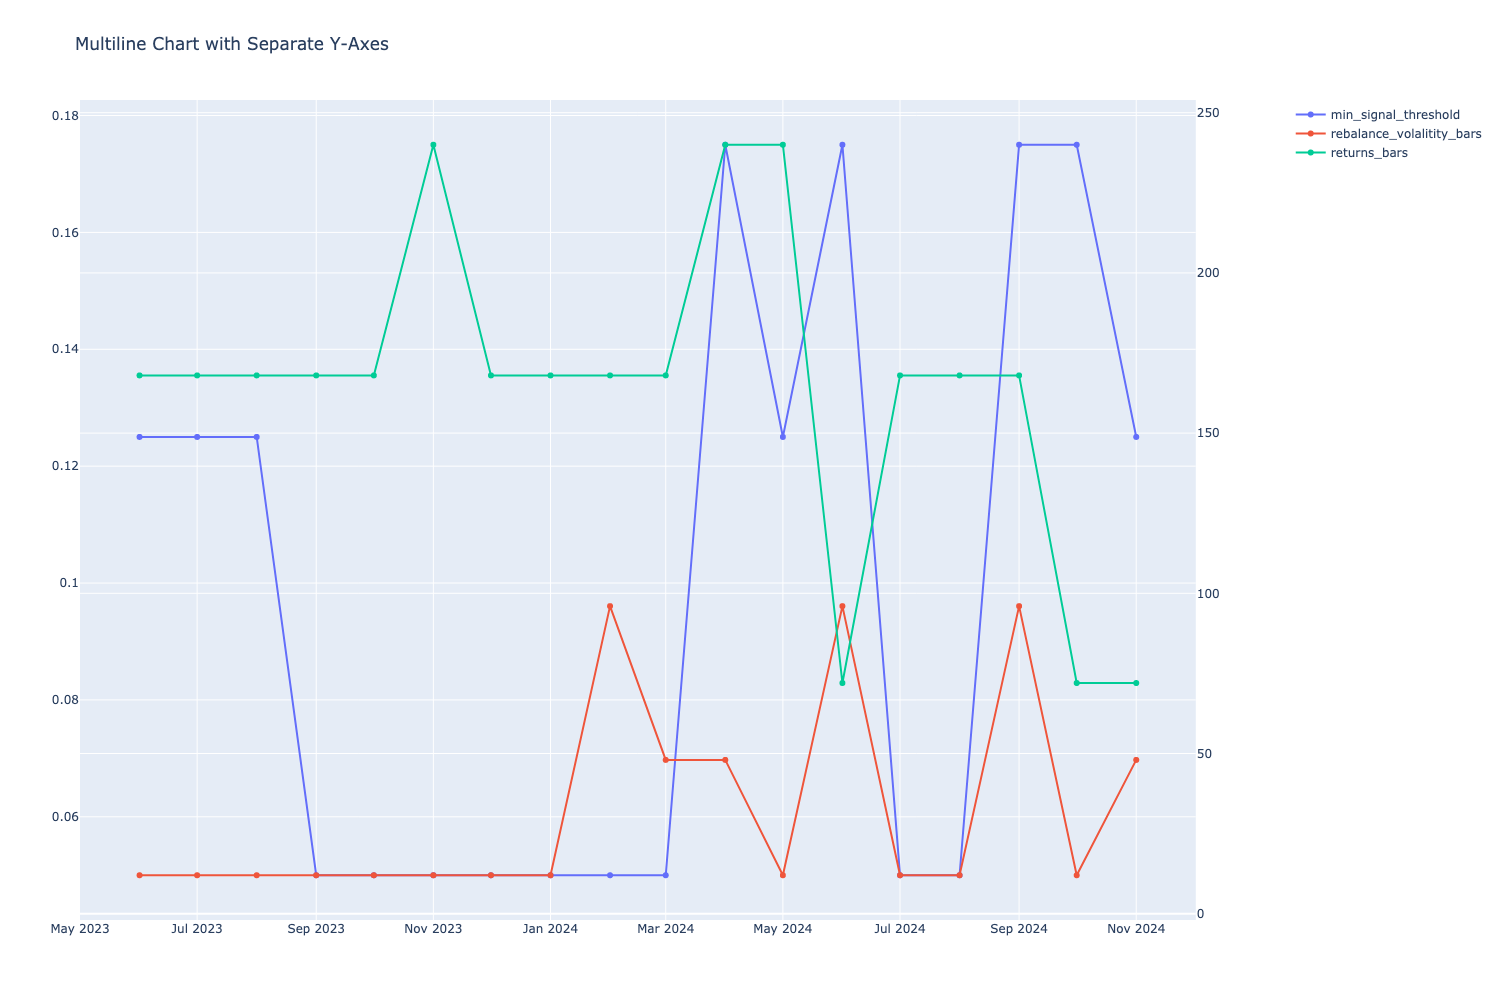

In [11]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with shared X-axis and multiple Y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

parameter_names = list(dynamic_parameters.keys())

# Add traces for each column with its own Y-axis
for i, col in enumerate(parameter_names):  # Skip the 'x' column
    fig.add_trace(
        go.Scatter(x=df.index, y=df[col], name=col),
        secondary_y=(i > 0)  # Use secondary Y-axis for all columns except the first
    )


# Update layout for better visualization
fig.update_layout(
    title="Multiline Chart with Separate Y-Axes",
    #margin=dict(l=510),
    )
fig.show()

# Set up dynamic parameters

- Each dynamic parameter is a dict of {start_date: value}

In [12]:
from tradeexecutor.backtest.grid_search import GridSearchResult, GridParameter
from tradeexecutor.strategy.parameters import RollingParameter
from tradeexecutor.strategy.parameters import display_parameters

# Construct RollingParameter instances
index = pd.DatetimeIndex(index)

print(f"Dynamic parameters are {len(dynamic_parameters)}:")
parameters = StrategyParameters.from_class(Parameters)
for key, values in dynamic_parameters.items():
    rolling_p = RollingParameter(
        name=key,
        freq=Parameters.optimiser_checkpoint_period,
        values=pd.Series(values, index=index)
    )
    parameters[key] = rolling_p
    print(rolling_p)

display_parameters(parameters)

Dynamic parameters are 3:
<RollingParameter min_signal_threshold freq=<MonthBegin> with 18 values between 2023-06-01 00:00:00 - 2024-11-01 00:00:00>
<RollingParameter rebalance_volalitity_bars freq=<MonthBegin> with 18 values between 2023-06-01 00:00:00 - 2024-11-01 00:00:00>
<RollingParameter returns_bars freq=<MonthBegin> with 18 values between 2023-06-01 00:00:00 - 2024-11-01 00:00:00>


Value  \
Name                                                                                        
allocation                                                                           0.95   
assummed_liquidity_when_data_missings                                               10000   
backtest_end                                                          2025-01-11 00:00:00   
backtest_start                                                        2023-05-03 00:00:00   
candle_time_bucket                                                          TimeBucket.h1   
categories                                                                         {Meme}   
chain_id                                                                                1   
cycle_duration                                                     CycleDuration.cycle_4h   
ewm_span                                                                              200   
exchanges                                                        {uniswap-v3, uniswap-v2}   
id                                                               31-eth-optimiser-periods   
individual_rebalance_min_threshold_usd                                               75.0   
initial_cash                                                                        10000   
max_assets_in_portfolio                                                                30   
max_concentration                                                                    0.33   
min_asset_universe                                                                      5   
min_liquidity                                                                      200000   
min_portfolio_weight                                                                0.005   
min_signal_threshold                    [0.125, 0.125, 0.125, 0.05, 0.05, 0.05, 0.05, ...   
min_token_sniffer_score                                                                30   
min_trade_count                                                                        50   
min_tvl                                                                             25000   
min_volume                                                                          50000   
optimiser_checkpoint_period                                                  <MonthBegin>   
optimiser_lookback_period                                                60 days, 0:00:00   
per_position_cap_of_pool                                                             0.01   
rebalance_volalitity_bars               [12, 12, 12, 12, 12, 12, 12, 12, 96, 48, 48, 1...   
required_history_period                                                  29 days, 0:00:00   
returns_bars                            [168, 168, 168, 168, 168, 240, 168, 168, 168, ...   
rolling_liquidity_bars                                                                168   
rolling_volume_bars                                                                   168   
routing                                                              TradeRouting.default   
slippage_tolerance                                                                  0.006   
trailing_sharpe_bars                                                                  336   
tvl_ewm_span                                                                          200   
use_aave                                                                            False   
grid_search                                                                         False   

                                                    Type  
Name                                                      
allocation                                         float  
assummed_liquidity_when_data_missings                int  
backtest_end                                    datetime  
backtest_start                                  datetime  
candle_time_bucket                            TimeBucket  
categories                                 

In [13]:
import logging
from pprint import pprint

from tradeexecutor.strategy.execution_context import notebook_execution_context
from tradeexecutor.strategy.pandas_trader.indicator import prepare_indicators


logging.getLogger().setLevel(logging.INFO)


indicator_set = prepare_indicators(
    indicators.create_indicators, 
    parameters, 
    strategy_universe, 
    notebook_execution_context, 
)

for x in indicator_set.indicators.items():
    print(x)

df = display_parameters(parameters)
display(df)

all_combinations = indicator_set.generate_combinations(strategy_universe)
for combination in all_combinations:    
    for key, value in combination.definition.parameters.items():
        assert not isinstance(value, list), f"Bad key: {key}, value: {value}, {value.__class__}, {combination.definition}"
        assert not isinstance(value, RollingParameter), f"RollingParameter not expanded: {key}, value: {value}, {value.__class__}, {combination.definition}"
    # print(combination)

logging.getLogger().setLevel(logging.WARNING)


('trailing_sharpe', <Indicator trailing_sharpe using trailing_sharpe for {'trailing_sharpe_bars': 336} >)
('trailing_sharpe_ewm', <Indicator trailing_sharpe_ewm using trailing_sharpe_ewm for {'trailing_sharpe_bars': 336, 'ewm_span': 200} >)
('volatility_faee793a', <Indicator volatility using volatility for {'rebalance_volalitity_bars': 12} w/variations>)
('volatility_ccba9532', <Indicator volatility using volatility for {'rebalance_volalitity_bars': 96} w/variations>)
('volatility_500b4618', <Indicator volatility using volatility for {'rebalance_volalitity_bars': 48} w/variations>)
('signed_volatility_3dc7e489', <Indicator signed_volatility using signed_volatility for {'rebalance_volalitity_bars': 12} w/variations>)
('signed_volatility_761ed61d', <Indicator signed_volatility using signed_volatility for {'rebalance_volalitity_bars': 96} w/variations>)
('signed_volatility_672f8412', <Indicator signed_volatility using signed_volatility for {'rebalance_volalitity_bars': 48} w/variations>)


Value  \
Name                                                                                        
allocation                                                                           0.95   
assummed_liquidity_when_data_missings                                               10000   
backtest_end                                                          2025-01-11 00:00:00   
backtest_start                                                        2023-05-03 00:00:00   
candle_time_bucket                                                          TimeBucket.h1   
categories                                                                         {Meme}   
chain_id                                                                                1   
cycle_duration                                                     CycleDuration.cycle_4h   
ewm_span                                                                              200   
exchanges                                                        {uniswap-v3, uniswap-v2}   
id                                                               31-eth-optimiser-periods   
individual_rebalance_min_threshold_usd                                               75.0   
initial_cash                                                                        10000   
max_assets_in_portfolio                                                                30   
max_concentration                                                                    0.33   
min_asset_universe                                                                      5   
min_liquidity                                                                      200000   
min_portfolio_weight                                                                0.005   
min_signal_threshold                    [0.125, 0.125, 0.125, 0.05, 0.05, 0.05, 0.05, ...   
min_token_sniffer_score                                                                30   
min_trade_count                                                                        50   
min_tvl                                                                             25000   
min_volume                                                                          50000   
optimiser_checkpoint_period                                                  <MonthBegin>   
optimiser_lookback_period                                                60 days, 0:00:00   
per_position_cap_of_pool                                                             0.01   
rebalance_volalitity_bars               [12, 12, 12, 12, 12, 12, 12, 12, 96, 48, 48, 1...   
required_history_period                                                  29 days, 0:00:00   
returns_bars                            [168, 168, 168, 168, 168, 240, 168, 168, 168, ...   
rolling_liquidity_bars                                                                168   
rolling_volume_bars                                                                   168   
routing                                                              TradeRouting.default   
slippage_tolerance                                                                  0.006   
trailing_sharpe_bars                                                                  336   
tvl_ewm_span                                                                          200   
use_aave                                                                            False   
grid_search                                                                         False   

                                                    Type  
Name                                                      
allocation                                         float  
assummed_liquidity_when_data_missings                int  
backtest_end                                    datetime  
backtest_start                                  datetime  
candle_time_bucket                            TimeBucket  
categories                                 

# Run backtest with dynamic parameters

- Do a single backtest run
- Use dynamically adjusted parameters for each 

In [14]:
parameters["backtest_start"] = datetime.datetime(2023, 7, 1)
parameters["backtest_end"] = datetime.datetime(2024, 11, 30)

print(f"Backtesting with rolling parameters {parameters['backtest_start']} - {parameters['backtest_end']}")

result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=indicators.create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Backtesting with rolling parameters 2023-07-01 00:00:00 - 2024-11-30 00:00:00


Reading cached indicators trailing_sharpe, trailing_sharpe_ewm, volatility_faee793a, volatility_ccba9532, vola…

Using indicator cache /Users/moo/.cache/indicators/ethereum_1h_105_2023-05-03-2025-01-11_ff


  0%|          | 0/44755200 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 4266 trades


# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [15]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
    interesting_assets=EXAMINED_ASSETS,
)

Strategy                 PEPE  \
Start Period                        2023-07-01           2023-07-01   
End Period                          2024-11-29           2024-11-29   
Risk-Free Rate                            0.0%                 0.0%   
Time in Market                           74.0%               100.0%   
Cumulative Return                    1,994.03%            1,184.48%   
CAGR﹪                                  340.44%              247.08%   
Sharpe                                     2.5                 1.83   
Prob. Sharpe Ratio                      99.97%               99.29%   
Smart Sharpe                              2.31                 1.69   
Sortino                                   5.26                 3.68   
Smart Sortino                             4.85                  3.4   
Sortino/√2                                3.72                  2.6   
Smart Sortino/√2                          3.43                  2.4   
Omega                                     1.69                 1.69   
Max Drawdown                           -38.25%              -66.39%   
Longest DD Days                            112                  238   
Volatility (ann.)                      107.39%               163.1%   
Calmar                                     8.9                 3.72   
Skew                                      2.38                 2.46   
Kurtosis                                 13.55                13.39   
Expected Daily                           0.59%                0.49%   
Expected Monthly                        19.59%                16.2%   
Expected Yearly                        357.61%               258.4%   
Kelly Criterion                         18.15%               23.76%   
Risk of Ruin                              0.0%                 0.0%   
Daily Value-at-Risk                     -8.51%              -13.22%   
Expected Shortfall (cVaR)               -8.51%              -13.22%   
Max Consecutive Wins                         7                    6   
Max Consecutive Losses                       6                    7   
Gain/Pain Ratio                           0.69                 0.35   
Gain/Pain (1M)                            3.78                 2.86   
Payoff Ratio                               2.1                 1.91   
Profit Factor                             1.69                 1.35   
Common Sense Ratio                        2.97                 1.78   
CPC Index                                 1.58                 1.29   
Tail Ratio                                1.76                 1.32   
Outlier Win Ratio                         7.22                 4.31   
Outlier Loss Ratio                        4.61                 2.95   
MTD                                     40.36%              107.26%   
3M                                      99.17%              162.13%   
6M                                      88.02%               18.23%   
YTD                                    413.31%              1405.0%   
1Y                                      674.0%             1736.66%   
3Y (ann.)                              340.44%              247.08%   
5Y (ann.)                              340.44%              247.08%   
10Y (ann.)                             340.44%              247.08%   
All-time (ann.)                        340.44%              247.08%   
Best Day                                 42.8%               62.49%   
Worst Day                              -17.17%              -22.11%   
Best Month                             172.98%              217.37%   
Worst Month                            -27.48%              -34.67%   
Best Year                              413.31%              1405.0%   
Worst Year                             307.94%              -14.65%   
Avg. Drawdown                          -13.45%              -22.92%   
Avg. Drawdown Days                          24                   42   
Recovery Factor                           9.95                

# Equity curve

- Equity curve shows how your strategy accrues value over time

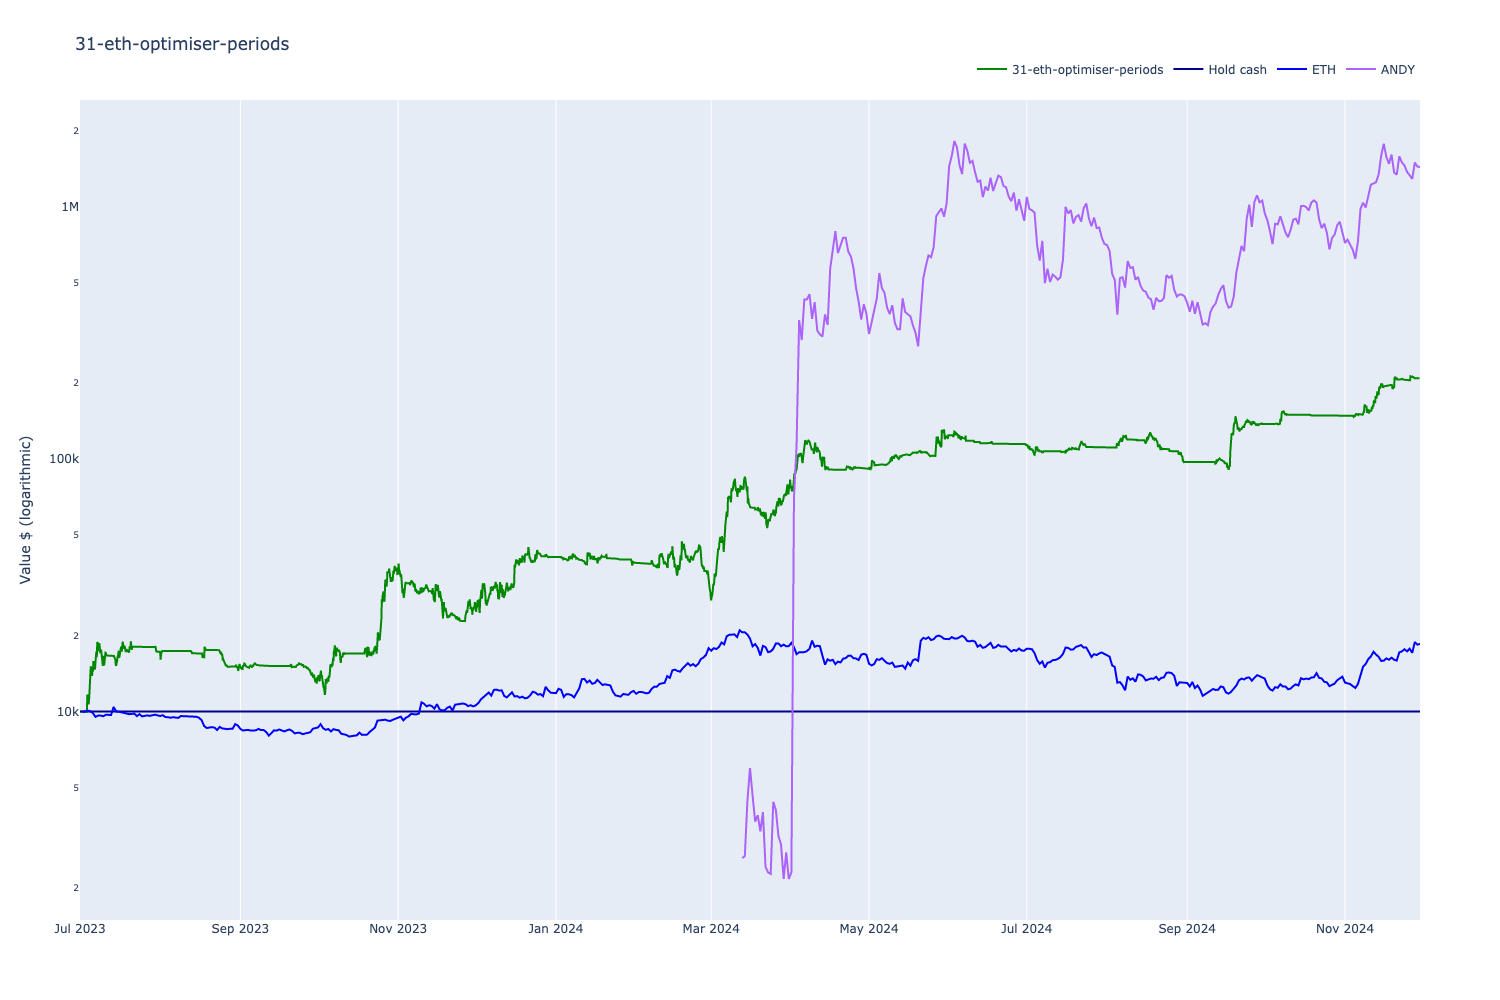

In [16]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
    start_at=state.get_trading_time_range()[0],
    interesting_assets=["WETH", "ANDY", "weirdo"],
)

fig = visualise_equity_curve_benchmark(
    state=state,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

## Equity curve with drawdown

- Linear curve

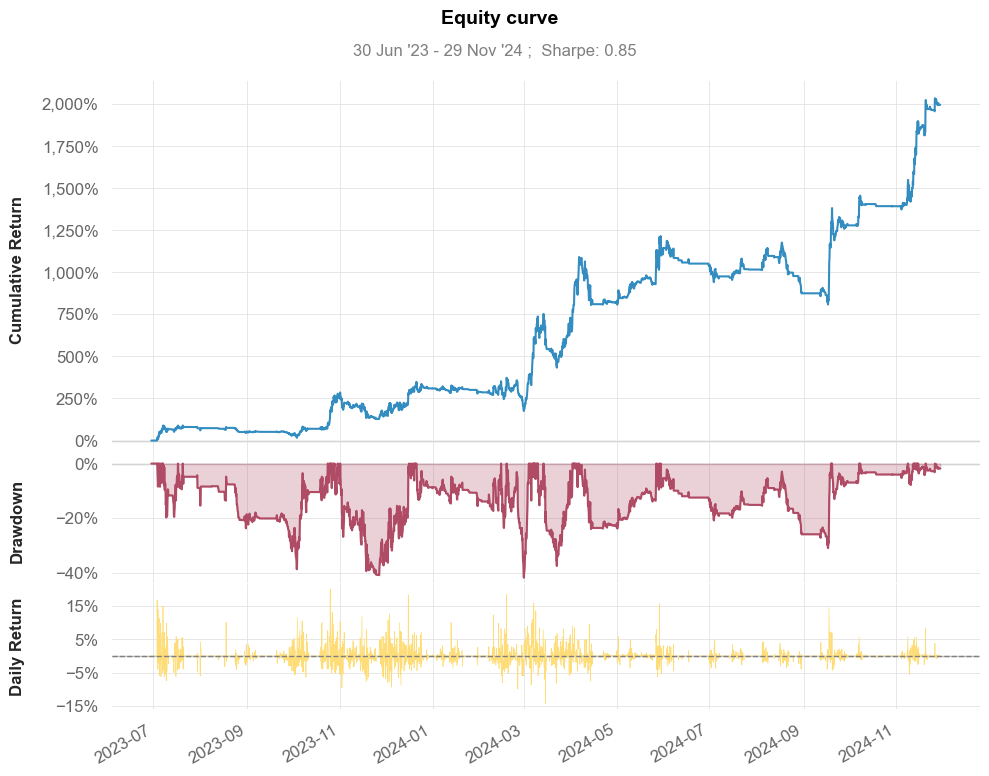

In [17]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
fig = visualise_equity_curve(returns)
display(fig)

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

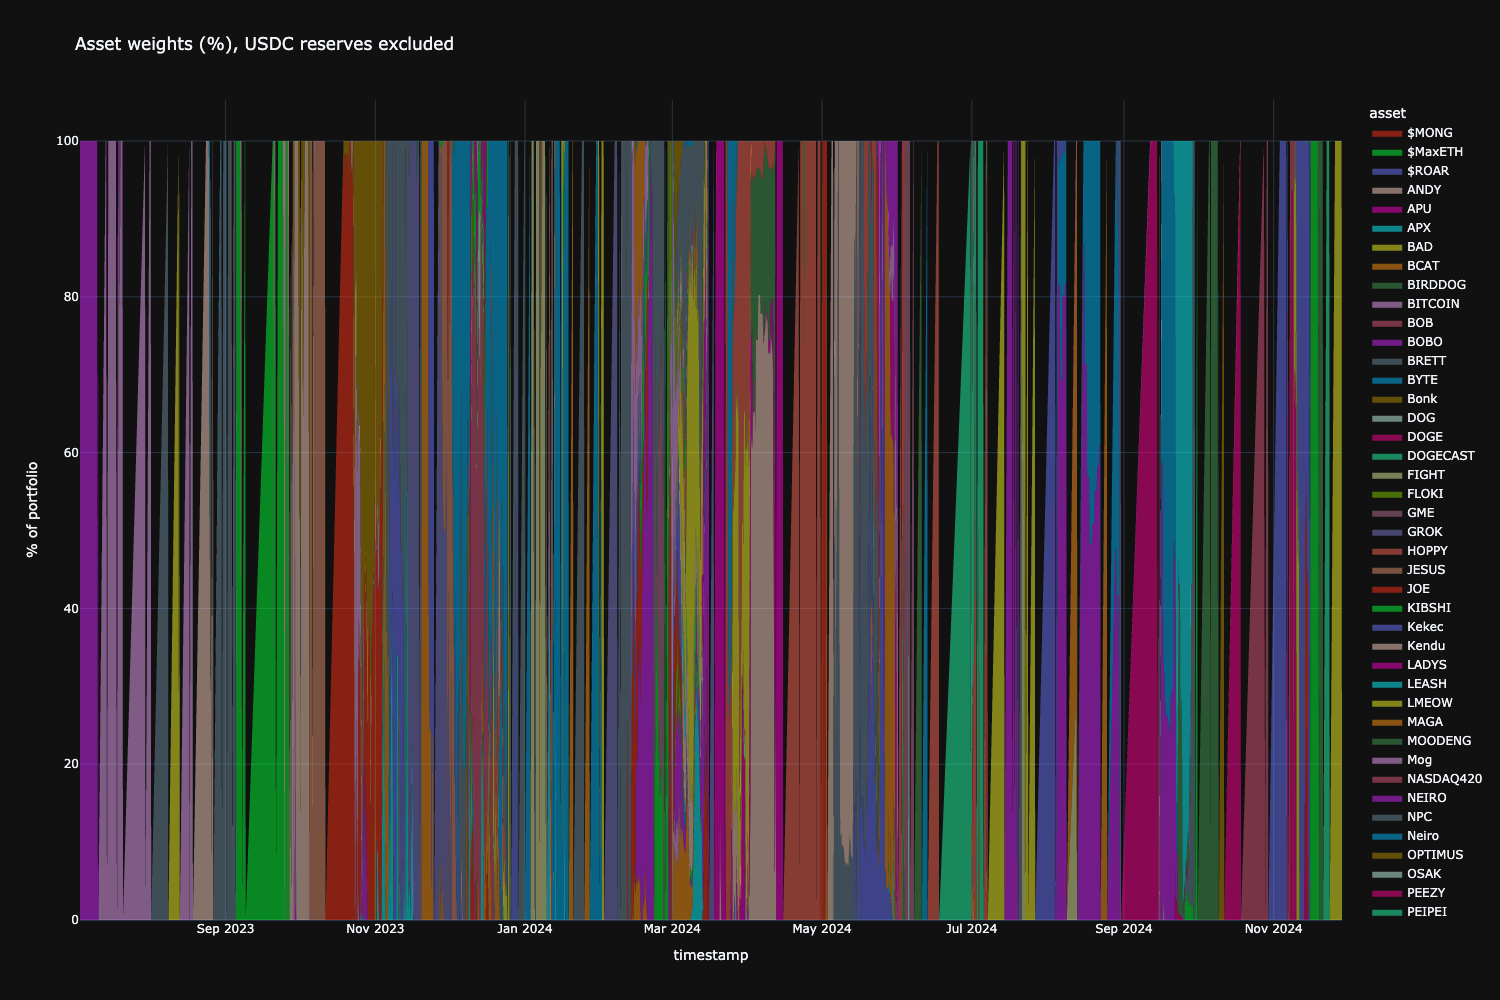

In [18]:
from tradeexecutor.analysis.weights import calculate_asset_weights, visualise_weights

weights_series = calculate_asset_weights(state)

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=False,
)
fig.show()

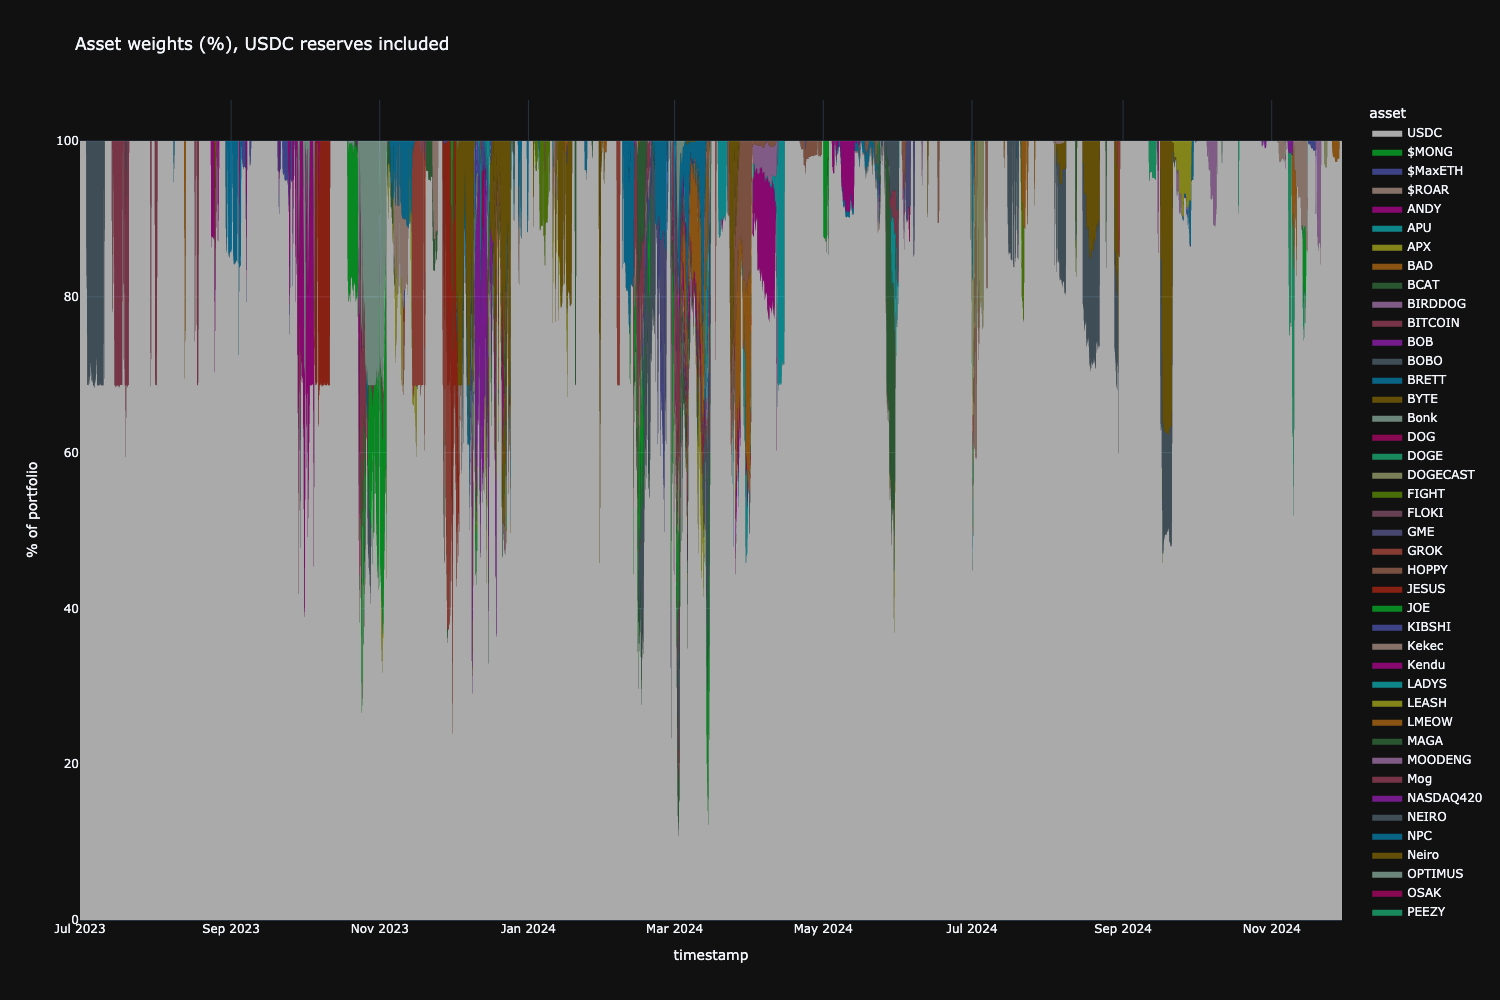

In [19]:

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=True,
)
fig.show()

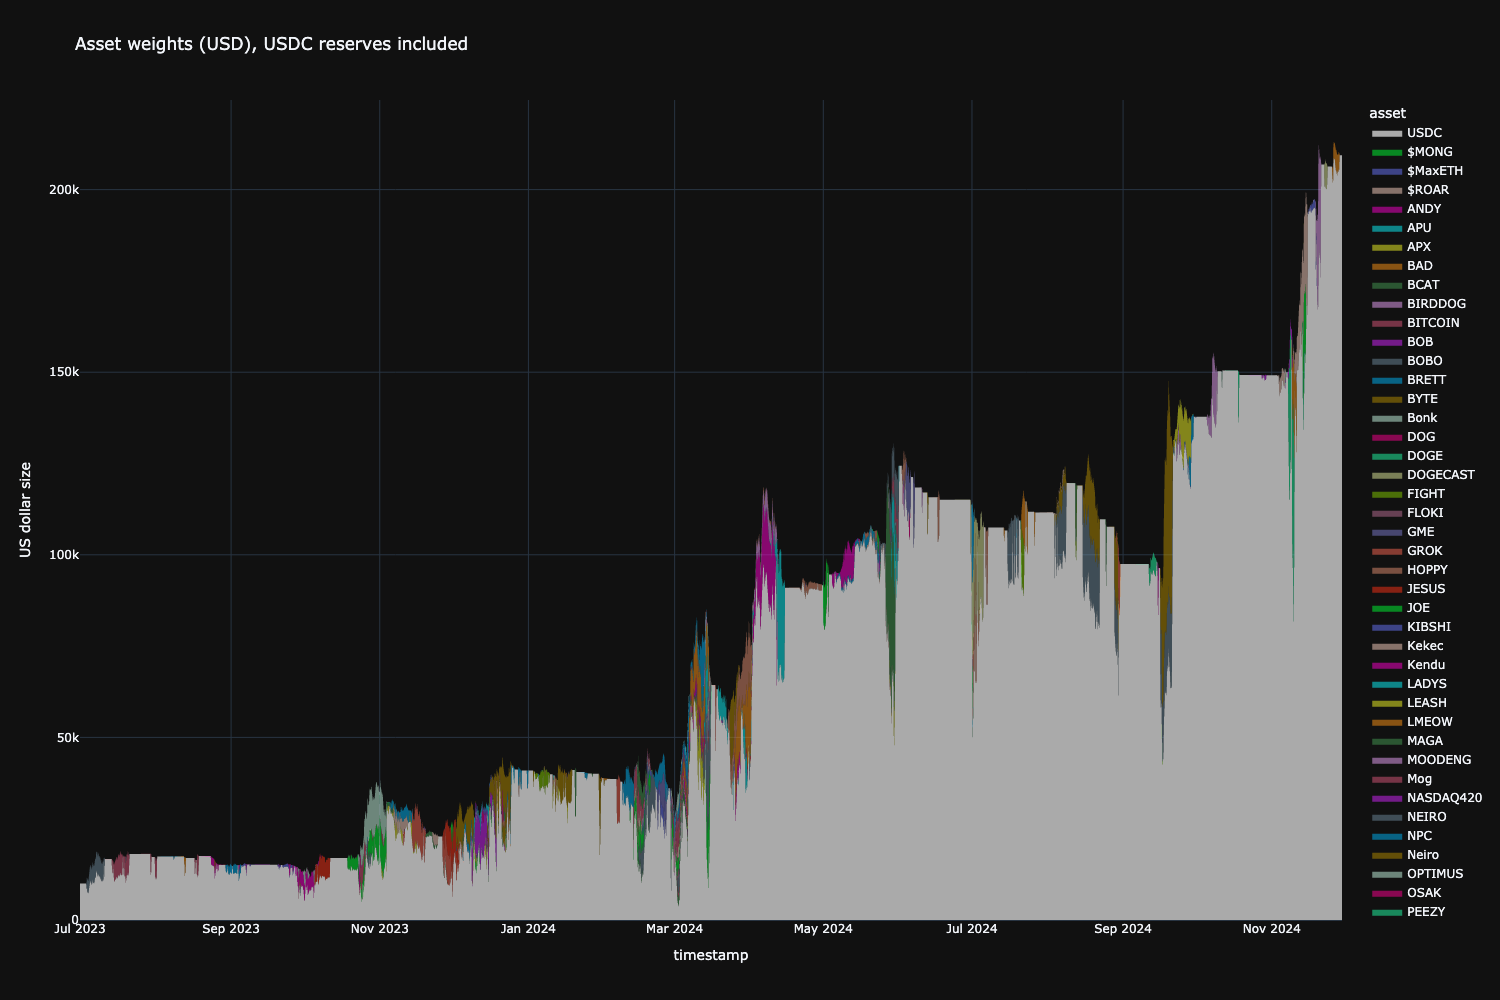

In [20]:
df = weights_series.unstack(level=1)

fig = visualise_weights(
    weights_series,
    normalised=False,
)
fig.show()

## Weight allocation statistics



In [21]:
from tradeexecutor.analysis.weights import calculate_weights_statistics

stats = calculate_weights_statistics(weights_series)
display(stats)


At   Pair      Value Unit
Name                                                                      
Max position (excluding USDC)   2024-09-19 16:00:00  Neiro  56,030.70  USD
Min position (excluding USDC)   2024-05-23 00:00:00   BCAT      33.53  USD
Mean position (excluding USDC)                               5,451.45  USD
Max position (excluding USDC)   2023-07-03 16:00:00   BOBO     100.00    %
Min position (excluding USDC)   2023-12-21 04:00:00  LMEOW       0.18    %
Mean position (excluding USDC)                                  40.91    %
Max position (including USDC)   2023-07-01 00:00:00   USDC     100.00    %
Min position (including USDC)   2024-09-24 20:00:00   DOGE       0.03    %
Mean position (including USDC)                                  40.80    %